In [3]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision.transforms.functional as TF
from torchvision import models 
from torch.autograd import Variable

import pandas as pd 
import numpy as np 
import os
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
!pip install opencv-python

In [5]:
import cv2

CAM models provide interpretability to AI, this had important ramifications in for three areas in ai 
-  Identify why a model is not providing the desired result 
-  Understanding the result of the model. Increase customer trust 
-  Training 

The concept behind a CAM-type model logic seems fairly trivial. The outputs of a convolution layer (before applying any downsampling activation function) will correspond to the 'weight maps' for the input. What does this mean?

The last convolutional layer will output k feature maps, where k is the number of kernels or filters in the layer. Each feature map (A_k) is the result of the convolution of the input to the layer with the kernel k. In CAM (and gradCAM), the feature map is turned into a k-dimensional vector g though a global average pooling layer and converted into class scores (y_c) for each class c, in the fully connected layer. 

The impact/importance of the activation layer into the final score, also called the neuron activation or weights, is computed differently in CAM vs GradCAM:

-CAM: can be precomputed during training but requires a last fully connected layer.

                      α_c,k = (1 / (H * W)) * W^(FC) 

-GradCAM (focus of this project): The weights are the global avg pooling (mean) of the gradients. There will be one gradient α_c per feature map A_k. Needs to be computed at runtime. 

           α_c,k = (1 / (H * W)) * Σ(Σ(∂y_c/∂A^(L)_k(i, j)))


Finally the feature maps A are multiplied by the pooled gradients (weights) adn summed along the channel dimension (K) 


#### Foundation 

- backprop
- compute dy/dA 
- compute alpha_c
- compute the gradients 

## Implementation using pytorch HOOKS

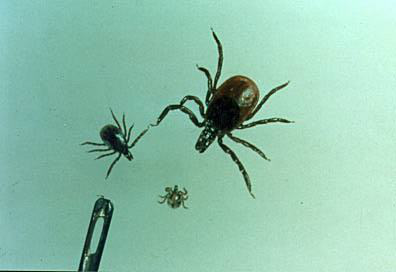

In [7]:
ROOT_DIR = os.path.abspath(os.path.dirname(__name__))
img = Image.open(os.path.join(ROOT_DIR, 'Data', os.listdir('Data')[0]))
img

In [8]:
# Implementation using hooks 
class ConvNeXt(nn.Module):
    
    def __init__(self):
        super(ConvNeXt, self).__init__()
        
        # weights 
        self.convnet = models.convnext_base(weights="IMAGENET1K_V1")
        
        # get the network up until the last conv layer
        self.feature_map_A = self.convnet.features[:8]
        
        # fininsh the network  
        self.pool = self.convnet.avgpool
        self.classifier = self.convnet.classifier 
#         self.tail = self.convnet.features[8:]
        
        #gradients
        self.gradients = None 
    
    #compute the ∂y_c/∂A
    def activations_hook(self, grad):
        self.gradients = grad
    
    def forward(self, x):
        x = self.feature_map_A(x)
        
        h = x.register_hook(self.activations_hook)
        
        x = self.pool(x)
        x = self.classifier(x)
        
        return x
    
    def get_activation_gradients(self): # optional
        return self.gradients
    
    def get_A(self, x): # optional
        return self.feature_map_A(x)
        

In [9]:
def compute_cam_hooks(img):
    cnv = ConvNeXt()
    cnv.eval()

    weights = models.ConvNeXt_Base_Weights.IMAGENET1K_V1
    preprocess = weights.transforms()

    batch = preprocess(img).unsqueeze(0)
    pred = cnv(batch).squeeze(0).softmax(0)
    class_id = pred.argmax().item()
    score = pred[class_id].item()

    # cnv.zero_grad()
    pred[class_id].backward()

    gradients = cnv.gradients # gradients shape: (N, K, H, W); N = batch size ,  K is the number of feature maps (channels) in the last convolutional layer, and H' and W' are the height and width of the feature maps, respectively

    #global avg pooling along H and W of the feature map
    pool_gradients = torch.mean(gradients, dim=(2, 3))  #
    #Shape: (K,) -> pools the gradients across the channels 

    activations = cnv.feature_map_A(batch).detach()
    #activation shape: (N, K, H, W)

    for i in range(activations.size()[1]): #K
        activations[:, i, :, :] *= pool_gradients[:, i] #weigh each activation by the weights 

    cam = torch.mean(activations, dim=1).squeeze()

    cam = np.maximum(cam, 0) #ReLu
    cam /= torch.max(cam) #normalize
    
    fig, axs = plt.subplots(nrows=2, ncols=2)
    
    axs[0, 0].imshow(cam.squeeze())
    resized_cam = cv2.resize(cam.squeeze().numpy(), img.size)
    axs[0, 1].imshow(resized_cam)
    axs[1, 0].imshow(img)
    superimposed_img = cv2.applyColorMap(np.uint8(resized_cam*255), cv2.COLORMAP_JET) * 0.001 + np.array(img)/255
    axs[1, 1].imshow(superimposed_img)
    
    category_name = weights.meta["categories"][class_id]
    fig.suptitle(f'{category_name=}; {score=}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


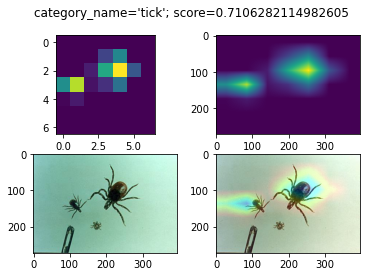

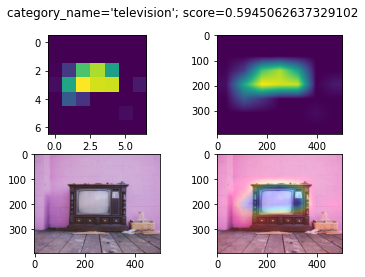

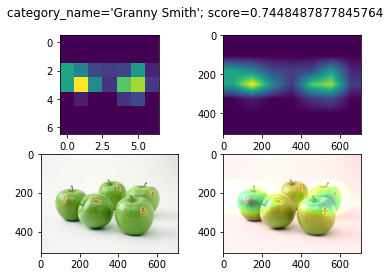

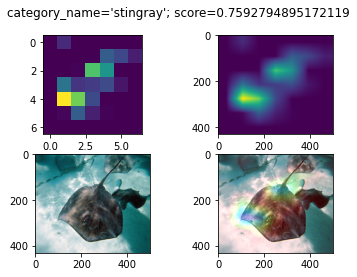

In [10]:
for img_dir in os.listdir('Data'):
    img = Image.open(os.path.join('Data', img_dir))
    compute_cam_hooks(img)

## Implementation raw 

 This implementation does not use hooks to retrieve the intermediate gradients 

In [14]:
# Implementation not using hooks 

class ConvNeXt(nn.Module):
    
    def __init__(self):
        super(ConvNeXt, self).__init__()
        
        # weights 
        self.convnet = models.convnext_base(weights="IMAGENET1K_V1")
        
        # get the network up until the last conv layer
        self.feature_map_A = self.convnet.features[:8]
        
        #create the max pooling operation for CAM
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
       
        # fininsh the network  
        self.pool = self.convnet.avgpool
        self.classifier = self.convnet.classifier
        
        #gradients
        self.gradients = None 
    
    def forward(self, x):
        x = self.feature_map_A(x)
        x = self.pool(x)
#         x = x.view(x.size(0),-1)
        x = self.classifier(x)
        
        return x
    
    def compute_weights(self, x):
    # computes the neuron activation matrix α_c,k
        
        # forward pass
        
        activations = self.feature_map_A(x) # shape N, K, W, H
        activations.retain_grad() #store gradients for non-leaf node
#         print(activations)
        
        pool_act = self.pool(activations)
        pred = self.classifier(pool_act).squeeze(0).softmax(0)
#         print(pred.shape)
        
        target_class = pred.argmax().item()
#         print(target_class)
        
        # backprop
        self.zero_grad()
        pred[target_class].backward(retain_graph=True)
        
        # gradients of activation
        self.gradient = activations.grad
        
        # CAM weights
        pooled_gradients = torch.mean(self.gradient, dim=[2,3])
        
        grad_cam = torch.zeros_like(activations)
        for i in range(activations.size()[1]):
            grad_cam[:, i, :, :] = activations[:, i, :, :] * pooled_gradients[:, i] 
        
        grad_cam = torch.mean(grad_cam, dim=1).squeeze()    
        
        return grad_cam

In [15]:
def compute_cam(img):
    cnv = ConvNeXt()
    cnv.eval()

    weights = models.ConvNeXt_Base_Weights.IMAGENET1K_V1
    preprocess = weights.transforms()
    
    batch = preprocess(img).unsqueeze(0)
    pred = cnv(batch).squeeze(0).softmax(0)
    class_id = pred.argmax().item()
    score = pred[class_id].item()
    
    cam = cnv.compute_weights(batch, ).detach().numpy()
    
    cam = np.maximum(cam, 0) #ReLu
    cam /= np.max(cam) #normalize
    
    fig, axs = plt.subplots(nrows=2, ncols=2)
    
    axs[0, 0].imshow(cam.squeeze())
    resized_cam = cv2.resize(cam, img.size)
    axs[0, 1].imshow(resized_cam)
    axs[1, 0].imshow(img)
    superimposed_img = cv2.applyColorMap(np.uint8(resized_cam*255), cv2.COLORMAP_JET) * 0.001 + np.array(img)/255
    axs[1, 1].imshow(superimposed_img)
    
    category_name = weights.meta["categories"][class_id]
    fig.suptitle(f'{category_name=}; {score=}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


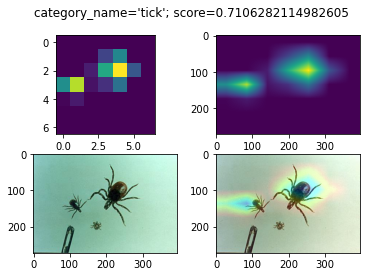

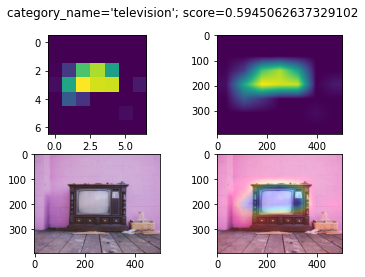

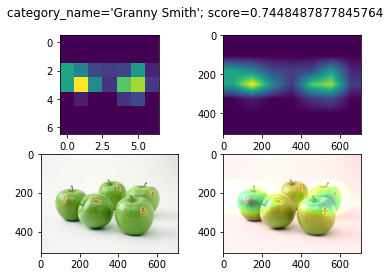

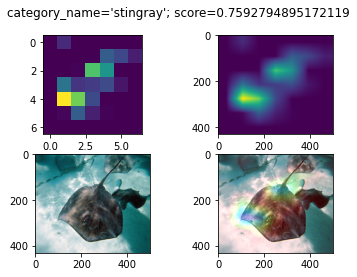

In [16]:
for img_dir in os.listdir('Data'):
    img = Image.open(os.path.join('Data', img_dir))
    compute_cam(img)